# Homework Weekend 6
## Regularizartion - Lasso and Ridge
### Sources
#### Reading:
- https://www.statisticshowto.datasciencecentral.com/lasso-regression/<br>
- https://codingstartups.com/practical-machine-learning-ridge-regression-vs-lasso/<br>
- https://www.datacamp.com/community/tutorials/tutorial-ridge-lasso-elastic-net<br>
- https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b<br>
- https://towardsdatascience.com/how-to-perform-lasso-and-ridge-regression-in-python-3b3b75541ad8<br>

#### Coding:
- https://datascienceplus.com/lasso-regression-in-python/<br>

#### Data:
- https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data <br>

### Setting up the Workshop

In [58]:
## Import Libraries
# Numpy Arrays and Array Math
import numpy as np
# DataFrames
import pandas as pd
# Fancy Visualizations
import seaborn as sns
# Basic Visualizations
import matplotlib

## Import Functions
#
from scipy.stats import skew
#
import matplotlib.pyplot as plt
#
from IPython.display import display, HTML
#
from scipy.stats.stats import pearsonr
#
from subprocess import check_output
# Ridge regression Model
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
#
from sklearn.model_selection import cross_val_score

## Homebrew Functions
# Returns the Root Mean Square Error of each k-folding (5 times) in across validation of a Model
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

## Settings
#
%matplotlib inline

### 01 Data Mining

In [4]:
## Importing Data
train = pd.read_csv('train.csv')
test  = pd.read_csv("test.csv")

In [17]:
# Combining 2 DataFrames into one
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

### 02 Data Exploring

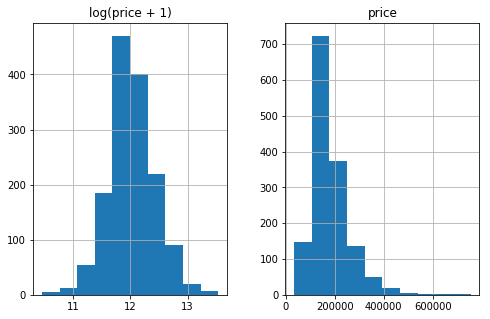

In [15]:
# Setting up Dictionary: Price - ln(1+Price)
new_price = {"price":train["SalePrice"], "log(price + 1)": np.log1p(train["SalePrice"])}
# Turn Dictionary into DataFrame
prices = pd.DataFrame(new_price)
# Handing over Parmeters for Plot
matplotlib.rcParams['figure.figsize'] = (8.0, 5.0)
# Plot
prices.hist()
plt.show()

<i>Thanks to the LN, the feature seems to be normalized.</i>

### 03 - Feature Engineering

In [25]:
# Transforming Salesprice Data via LN
train["SalePrice"] = np.log1p(train["SalePrice"])
# Saving the Names of all numerical (non-object) Features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
# Calculate the Skewness
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
# Save the Features with a Skewness greater than 0.75
skewed_feats = skewed_feats[skewed_feats > 0.75]
# Save the Names of the Features instead
skewed_feats = skewed_feats.index
# Show these Features
skewed_feats

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

In [26]:
# Do the LN-Transformation on all data, on all numerical Features
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

//anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log1p
  


In [44]:
# Create Dummy Features
all_data = pd.get_dummies(all_data)
# Fill missing Values with Mean of each Feature
all_data = all_data.fillna(all_data.mean())
# Seperate back into Training and Testing Data
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
# Define Training's Data Dependent Feature (aka the Target)
y = train.SalePrice

### 04 - Predictive Modeling

In [51]:
## Evaluate a score by cross-validation
# Estimator: Ridge Function ||y - Xw||^2_2 + alpha * ||w||^2_2
# Independent Training Features
# Target Feature
# scoring type negative mean squared error
# Kfold of 5
cross_val_score(Ridge(), X_train, y, scoring="neg_mean_squared_error", cv = 5)

array([-7.88645189e-05, -1.14947771e-04, -1.12175054e-04, -7.63097167e-05,
       -1.40010784e-04])

In [57]:
# Transform the Output into Root-mean-square-error
rmse_ridge = np.sqrt(-cross_val_score(Ridge(), X_train, y, scoring="neg_mean_squared_error", cv = 5))
rmse_ridge

array([0.00888057, 0.01072137, 0.01059127, 0.00873554, 0.01183262])

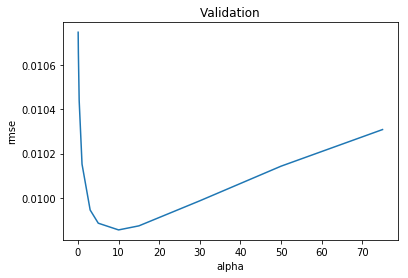

In [60]:
# Setting Different Alphas for the Ridge Function
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
# Calculatin the Mean RSME for each Alpha
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]
# Turn Results into Pandas
cv_ridge = pd.Series(cv_ridge, index = alphas)
# Draw Plot
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

In [61]:
## Minimum Error
cv_ridge.min()

0.009856187303325305

In [62]:
# Create LassoCV Machine, feed it the training Data and 4 Alphas
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
# Calculate the mean RSME
rmse_cv(model_lasso).mean()

//anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
//anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
//anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
//anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of rely

0.011227594909962859

In [68]:
# Extract the Coeficients of the Machine
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
coef.unique()

array([-0.00000000e+00,  6.12920756e-03,  7.33194713e-03,  2.74410079e-03,
        2.33009890e-04,  1.40529423e-04,  1.04757238e-03,  9.91288085e-04,
        2.62203288e-03,  1.28397133e-02,  2.05936120e-03,  3.21109969e-03,
       -3.40310977e-05,  1.74143261e-04,  1.96113237e-05,  3.89135916e-04,
        2.58484379e-04,  2.04300110e-04,  7.57120247e-04, -1.62251613e-04,
       -1.51061748e-04,  1.55443357e-04,  7.95897089e-04, -1.23359188e-05])

In [69]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 23 variables and eliminated the other 265 variables


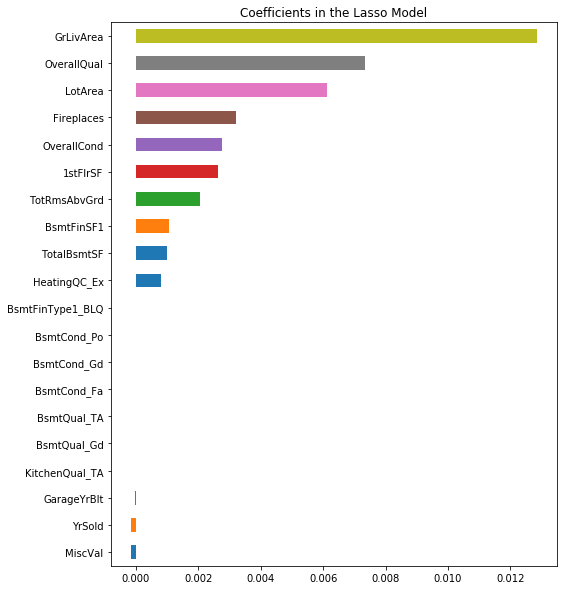

In [70]:
# Get the Lowest 10, and the Highest 10 Coeefficients
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
# Plot Coeficients
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

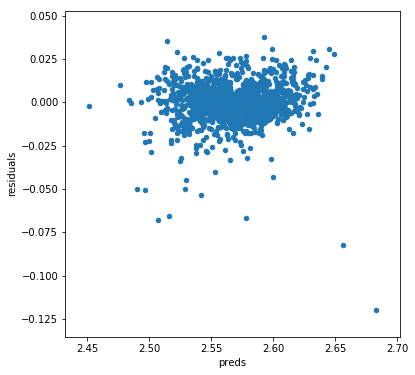

In [73]:
# Set Parameters for Plot
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
#  Extract Predictions and actual Values
preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
# Calculate the Residuals
preds["residuals"] = preds["true"] - preds["preds"]
# Scatter Plot Prediction / Residual
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.show()

### Open Questions
- What are Dummy Variabels being made for/ of in 03?<br>
- Why are my values different from the Blog?<br>